# Decission Tree Regression Workflow

This file demonstrates the workflow used for optimizing, training, and evaluating the decission tree regression models developed for predicting the soft phonon frequency of KTaO3 based on irreducible representation order parameters, strain tensor components, and structural metrics.

### Import the datasets

In [200]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/irrep_order_parameter_magnitudes_and_phonon_frequency_dataset.csv')
df1 = pd.read_csv('data/strain_tensor_component_and_phonon_frequency_dataset.csv')
df2 = pd.read_csv('data/octahedron_structure_metrics_and_phonon_frequency_dataset.csv')
df3 = pd.read_csv('data/irrep_order_parameter_magnitudes_and_phonon_frequency_dataset_large.csv')

### Datasets to be trained on:

Irreducible representation order parameter magnitudes:

In [123]:
df

,gm1,gm3_a0,gm3_0a,gm5_a00,gm5_0a0,gm5_00a,frequency
0,-0.005,0.00,-0.0024,0.00,-0.01,0.00,7909.790147
1,-0.005,0.00,-0.0024,0.00,-0.01,0.01,7619.874234
2,-0.005,0.00,-0.0024,0.00,-0.01,-0.01,7619.800560
3,-0.005,0.00,-0.0024,0.00,0.00,-0.01,7620.930328
4,-0.005,0.00,-0.0024,0.00,0.00,0.00,7888.340652
...,...,...,...,...,...,...,...
724,0.005,-0.01,-0.0024,-0.01,0.01,0.01,-7144.198048
725,0.005,-0.01,-0.0024,-0.01,0.01,-0.01,-7166.562992
726,0.005,-0.01,-0.0024,-0.01,-0.01,0.00,-7022.370614
727,0.005,-0.01,-0.0024,-0.01,-0.01,0.01,-7166.570611


Strain tensor components:

In [124]:
df1

,exx,eyy,ezz,exy,exz,eyz,frequency
0,0.01,0.00,-0.01,-0.01,-0.01,0.01,-11388.702497
1,0.01,0.00,-0.01,-0.01,-0.01,0.00,-11396.867022
2,0.01,0.00,-0.01,-0.01,-0.01,-0.01,-11384.635415
3,0.01,0.00,-0.01,-0.01,0.01,-0.01,-11388.595566
4,0.01,0.00,-0.01,-0.01,0.01,0.00,-11396.777134
...,...,...,...,...,...,...,...
724,-0.01,-0.01,0.00,0.01,0.01,-0.01,2481.243214
725,-0.01,-0.01,0.00,0.01,0.01,0.00,2593.318450
726,-0.01,-0.01,0.00,0.01,-0.01,-0.01,2467.418950
727,-0.01,-0.01,0.00,0.01,-0.01,0.00,2593.290136


Octahedron structure metrics:

In [125]:
df2


,average bond length,distortion index,bond angle variance,frequency
0,1.988859,0.001129,0.240535,7909.790147
1,1.988893,0.001140,0.480232,7619.874234
2,1.988893,0.001140,0.480232,7619.800560
3,1.988859,0.001146,0.239718,7620.930328
4,1.988826,0.001135,0.000000,7888.340652
...,...,...,...,...
724,2.000441,0.005427,0.707081,-7144.198048
725,2.000441,0.005427,0.717123,-7166.562992
726,2.000408,0.005433,0.474186,-7022.370614
727,2.000441,0.005427,0.717123,-7166.570611


### Prepare data for training and testing

Convert each of the above dataframes to their respective target matrices and feature vectors.

In [88]:
order_param_features = df[['gm1','gm3_a0','gm3_0a','gm5_a00','gm5_0a0','gm5_00a']]
order_param_target = df['frequency']

strain_component_features = df1[['exx','eyy','ezz','exy','exz','eyz']]
strain_component_target = df1['frequency']

structure_metric_features = df2[['average bond length','distortion index','bond angle variance']]
structure_metric_target = df2['frequency']


Scale each of the datasets into training and testing sets. We chose to use a 75/25 split as shown below.

In [89]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

#Split data into test and train sets
irrep_features_train, irrep_features_test, irrep_target_train, irrep_target_test = train_test_split(order_param_features, 
                                                                                                    order_param_target, 
                                                                                                    test_size=0.25, random_state=11)
strain_features_train, strain_features_test, strain_target_train, strain_target_test = train_test_split(strain_component_features, 
                                                                                                    strain_component_target, 
                                                                                                    test_size=0.25, random_state=4)
struc_features_train, struc_features_test, struc_target_train, struc_target_test = train_test_split(structure_metric_features, 
                                                                                                    structure_metric_target, 
                                                                                                    test_size=0.25, random_state=6)

Scale the training feature datasets. We chose to use the StandardScalar package provided by Scikit Learn since the feature distributions in each dataset are normal.

In [90]:
from sklearn import preprocessing

irrep_scaler = preprocessing.StandardScaler().fit(irrep_features_train)  
irrep_features_train_scaled = irrep_scaler.transform(irrep_features_train)
irrep_features_test_scaled = irrep_scaler.transform(irrep_features_test)

strain_scaler = preprocessing.StandardScaler().fit(strain_features_train)  
strain_features_train_scaled = strain_scaler.transform(strain_features_train)
strain_features_test_scaled = strain_scaler.transform(strain_features_test)

struc_scaler = preprocessing.StandardScaler().fit(struc_features_train)  
struc_features_train_scaled = struc_scaler.transform(struc_features_train)
struc_features_test_scaled = struc_scaler.transform(struc_features_test)

### Use cross-validation to perform a grid-search for the most optimal hyperparameters

In [91]:
#Declare functions for performing cross validation and calculating error
def get_rmse(actual, pred):
    return np.mean([(actual[i]-pred[i])**2 for i in range(len(actual))])**0.5

def run_cv(n_folds, model, X_train, y_train, stratify=False):
    """
    Args:
        n_folds (int) : how many folds of CV to do
        model (sklearn Model) : what model do we want to fit
        X_train (np.array) : feature matrix
        y_train (np.array) : target array
        stratify (bool) : if True, use stratified CV, otherwise, use random CV
        
    Returns:
        a dictionary with scores from each fold for training and validation
            {'train' : [list of training scores],
             'val' : [list of validation scores]}
            - the length of each list = n_folds
    """
    if stratify:
        folds = StratifiedKFold(n_splits=n_folds).split(X_train, y_train)
    else:
        folds = KFold(n_splits=n_folds).split(X_train, y_train)

    train_scores, val_scores = [], []
    for k, (train, val) in enumerate(folds):

        X_train_cv = X_train[train]
        y_train_cv = y_train[train]

        X_val_cv = X_train[val]
        y_val_cv = y_train[val]

        model.fit(X_train_cv, y_train_cv)

        y_train_cv_pred = model.predict(X_train_cv)
        y_val_cv_pred = model.predict(X_val_cv)

        train_acc = get_rmse(y_train_cv, y_train_cv_pred)
        val_acc = get_rmse(y_val_cv, y_val_cv_pred)

        train_scores.append(train_acc)
        val_scores.append(val_acc)

    print('%i Folds' % n_folds)
    print('Mean training error = %.3f +/- %.4f' % (np.mean(train_scores), np.std(train_scores)))
    print('Mean validation error = %.3f +/- %.4f' % (np.mean(val_scores), np.std(val_scores)))
    
    training_rmse.append(np.mean(train_scores))
    training_std.append(np.std(train_scores))
    validation_rmse.append(np.mean(val_scores))
    validation_std.append(np.std(val_scores))
    

    return {'train' : train_scores,
           'val' : val_scores}

We chose to perform a 10-fold cross-validation. The hyperparameters we consider for devloping decission tree regression models are the max depth, minimum samples per leaf, and the mininum weight fraction per leaf. Please refer to the documentation provided by Scikit Learn for greater detail.

In [101]:
from sklearn.tree import DecisionTreeRegressor

max_depth = np.arange(1,16)
min_samples_leaf = np.arange(1,11,1)
min_weight_fraction_leaf = np.arange(0,0.6,0.1)
n_folds = 10

#Iterate through all hyperparamter values of interest to perform grid search

def grid_search(X_train_scaled, y_train):
    grid_search_df = pd.DataFrame()
    md = []
    msl = []
    mwfl = []
    tr_rmse = []
    avg_tr_rmse = []
    val_rmse = []
    avg_val_rmse = []
    for j in max_depth:
        for k in min_samples_leaf:
            for l in min_weight_fraction_leaf:
                training_rmse, training_std = [], []
                validation_rmse, validation_std = [], []
                model = DecisionTreeRegressor(max_depth=j, min_samples_leaf=k, min_weight_fraction_leaf=l, random_state=14)                           
                cv_scores = run_cv(n_folds=n_folds,
                                    model=model,
                                    X_train=X_train_scaled,
                                    y_train=y_train)
                md.append(j)
                msl.append(k)
                mwfl.append(l)
                tr_rmse.append(cv_scores['train'])
                avg_tr_rmse.append(np.mean(cv_scores['train']))
                val_rmse.append(cv_scores['val'])
                avg_val_rmse.append(np.mean(cv_scores['val']))
                
    grid_search_df['max depth'] = md
    grid_search_df['min samples per leaf'] = msl
    grid_search_df['min weight fraction per leaf'] = mwfl
    grid_search_df['train rmse'] = tr_rmse
    grid_search_df['validation rmse'] = val_rmse
    grid_search_df['average train rmse'] = avg_tr_rmse
    grid_search_df['average validation rmse'] = avg_val_rmse

    return grid_search_df


Format target data for training so that its compatible with the cross-validation function

In [102]:
irrep_target_train = np.array(irrep_target_train).reshape(-1, 1)
strain_target_train = np.array(strain_target_train).reshape(-1,1)
struc_target_train = np.array(struc_target_train).reshape(-1,1)

Perform the grid search for each dataset

In [113]:
irrep_grid_search_results = grid_search(irrep_features_train_scaled, irrep_target_train)
strain_grid_search_results = grid_search(strain_features_train_scaled, strain_target_train)
struc_grid_search_results = grid_search(struc_features_train_scaled, struc_target_train)

10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean training error = 6113.983 +/- 43.4975
Mean validation error = 6111.607 +/- 394.4982
10 Folds
Mean training error = 6113.983 +/- 43.4975
Mean validation error = 6111.607 +/- 394.4982
10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean training error = 4432.362 +/- 41.8614
Mean validation error = 4427.442 +/- 374.4759
10 Folds
Mean traini

### Analyze grid-search results

In [126]:
irrep_grid_search_results_data = irrep_grid_search_results.copy()
strain_grid_search_results_data = strain_grid_search_results.copy()
struc_grid_search_results_data = struc_grid_search_results.copy()

Here we focus on the irreducible representation order parameter model. Those who are interested in optimizing and training models for the strain tensor components and octahedron structure metrics datasets can use the same workflow provided below. A larger dataset of order parameters is also provided which can be trained on to compare the performance of models trained on the same type of data but with different amounts (729 vs 15625 samples).

In [182]:
irrep_grid_search_matrix = irrep_grid_search_results_data[['max depth','min samples per leaf','min weight fraction per leaf','average validation rmse','average train rmse']].to_numpy()
max_depth_min_samples_array = []
max_depth_min_weight_array = []

for i, value in enumerate(irrep_grid_search_matrix[:,2]):
    if value == 0:
        max_depth_min_samples_array.append(irrep_grid_search_matrix[i,:].tolist()) 
for i, value in enumerate(irrep_grid_search_matrix[:,1]):
    if value == 1:
        max_depth_min_weight_array.append(irrep_grid_search_matrix[i,:].tolist())  

max_depth_min_samples_array_reshaped = np.array(max_depth_min_samples_array)
max_depth_min_weight_array_reshaped = np.array(max_depth_min_weight_array)

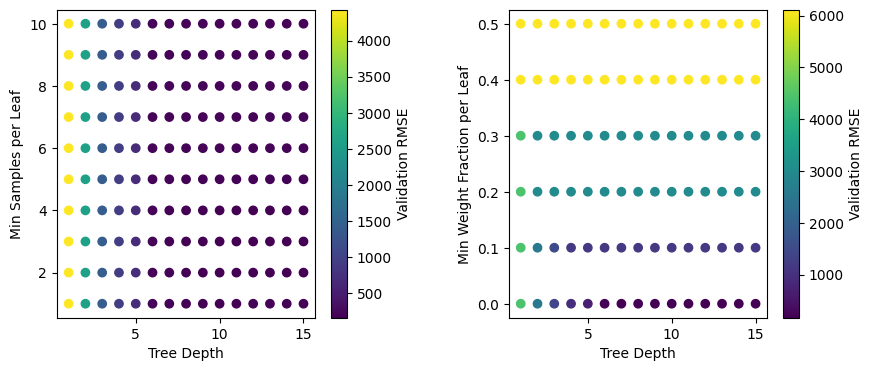

In [183]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sc1 = ax1.scatter(max_depth_min_samples_array_reshaped[:,0], max_depth_min_samples_array_reshaped[:,1], c=max_depth_min_samples_array_reshaped[:,3], cmap='viridis')
ax1.set_xlabel('Tree Depth')
ax1.set_ylabel('Min Samples per Leaf')
cb1 = fig.colorbar(sc1, ax=ax1)
cb1.set_label('Validation RMSE')  # Title for the colorbar

sc2 = ax2.scatter(max_depth_min_weight_array_reshaped[:,0], max_depth_min_weight_array_reshaped[:,2], c=max_depth_min_weight_array_reshaped[:,3], cmap='viridis')
ax2.set_xlabel('Tree Depth')
ax2.set_ylabel('Min Weight Fraction per Leaf')
cb2 = fig.colorbar(sc2, ax=ax2)
cb2.set_label('Validation RMSE')  # Title for the colorbar

plt.subplots_adjust(wspace=0.4)  # Adjust the width space between plots
plt.show()

The above plots indicate that the models accuracy is greatest for low minimum samples per leaf and minimum weight fraction per leaf. Further inspection can be given to optimizing the model baed on tree depth as shown below.

[]

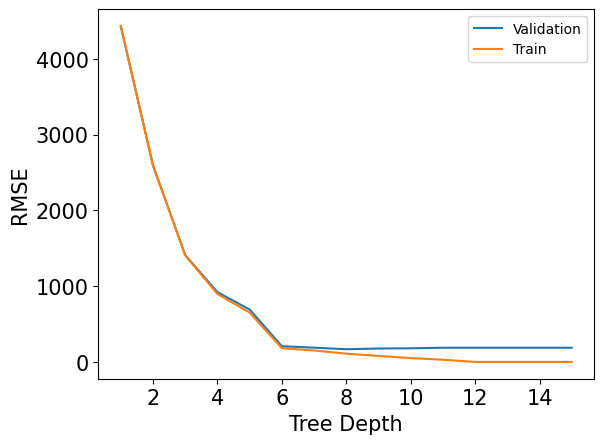

In [199]:
max_depth_data = []
for i, value in enumerate(irrep_grid_search_matrix[:,2]):
    if irrep_grid_search_matrix[i,2]==0 and irrep_grid_search_matrix[i,1]==1:
        max_depth_data.append(irrep_grid_search_matrix[i,:].tolist()) 
 
max_depth_data_reshaped = np.array(max_depth_data)

plt.plot(max_depth_data_reshaped[:,0],max_depth_data_reshaped[:,3])
plt.plot(max_depth_data_reshaped[:,0],max_depth_data_reshaped[:,4])
plt.legend(['Validation','Train'],fontsize=10)
plt.xlabel('Tree Depth',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot()

The curves in the plot above indicate that the performance of the model does not improve much beyond a tree depth of 6 as shown by the flat validation curve. Using a tree depth greater than 6 increases risk of over-fitting as shown by the training curve that continues to approach zero.

### Fit the models for each dataset with optimized hyperparameters

In [226]:
irrep_optimized_model = DecisionTreeRegressor(max_depth=6,min_samples_leaf=1,min_weight_fraction_leaf=0,random_state=10).fit(irrep_features_train_scaled,irrep_target_train)
irrep_target_prediction = irrep_optimized_model.predict(irrep_features_test_scaled)
r_square = irrep_optimized_model.score(irrep_features_test_scaled,irrep_target_test)

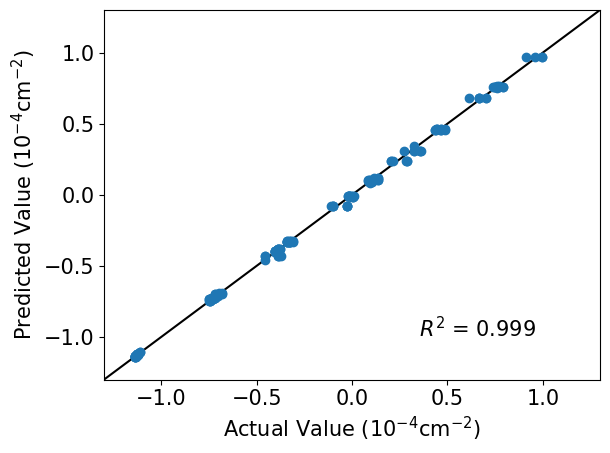

In [227]:
plt.plot(np.linspace(-3.5,1.5,100),np.linspace(-3.5,1.5,100),color='black')
plt.plot(irrep_target_test/10000, irrep_target_prediction/10000, marker='o', linestyle='none',color='C0')
plt.xlabel('Actual Value (10$^{-4}$cm$^{-2}$)', fontsize=15)
plt.ylabel('Predicted Value (10$^{-4}$cm$^{-2}$)', fontsize=15)
plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.35,-1, "$R^2$ = {:.3f}".format(r_square),fontsize=15)
plt.show()

### Feauture Importance Analysis

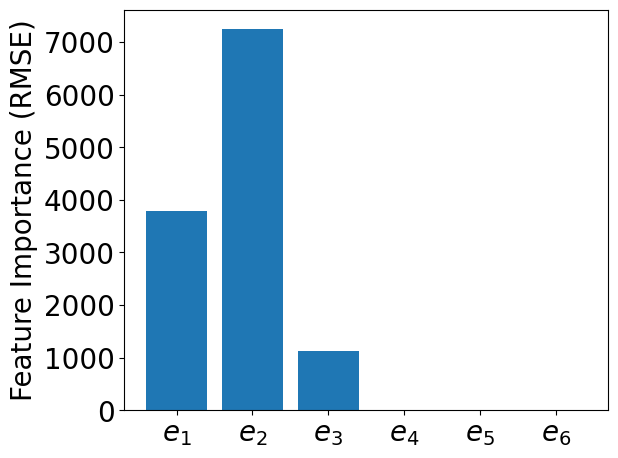

In [228]:
from sklearn.inspection import permutation_importance

feat_impt1 = permutation_importance(irrep_optimized_model,irrep_features_train_scaled,irrep_target_train,random_state=4,scoring='neg_root_mean_squared_error')
mean_importances = feat_impt1.importances_mean
std_dev_importances = feat_impt1.importances_std
features  = ['$e_{1}$','$e_{2}$','$e_{3}$','$e_{4}$','$e_{5}$','$e_{6}$']

plt.bar(features,mean_importances)
plt.ylabel('Feature Importance (RMSE)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout(pad=1.5)
plt.show()

The bar plot above indicates that the first three order parameters along the y-axis contribute to the greatest amount of variability in the target parameter of interest. In this case, our target property is the soft phonon frequency of KTO which is known to cause a lattice instabilitiy under sufficient biaxial strain. The above result confirms this experimental realization by showing that the second order parameter which is associated with biaxial strain with volume conservation has the greatest influence on the soft phonon frequency. Second in importance to biaxial strain is the first order parameter which is associated with volumetric strain. Using order parameters as features in this model serves as useful method to distinguish specific distortions that contribute to emergent phenomena in this system.